# Hyperparameter Tuning for Adaptive Synergy on Point-Mass

This notebook uses a simpler, faster meta-reinforcement learning benchmark (`Point-Mass-v0`) to rigorously tune the key hyperparameters of the **Adaptive Synergy (DRL + Meta + ES)** framework. The faster iteration speed of this environment makes it feasible to use automated tuning tools like Optuna on a standard laptop.

### Workflow:

1.  **Define a Simpler Benchmark:** A custom `MetaPointMassEnv` is created. The 'task' is to navigate a point-mass to a specific goal location, which changes at set intervals. This is a standard and credible benchmark for meta-RL.

2.  **Ensure Reproducibility:** A comprehensive seeding function is implemented to control randomness from `torch`, `numpy`, and the `gymnasium` environment, ensuring that results are reproducible.

3.  **Automated Hyperparameter Tuning:** The `Optuna` library is used to perform a Bayesian optimization search over the most critical hyperparameters:
    - `ppo_lr` (DRL Learning Rate)
    - `meta_loss_coef` (Meta-Learning Weight)
    - `es_reg_coef` (Evolutionary Regularization Weight)

4.  **Save Best Parameters:** The best-performing hyperparameter set found by Optuna is saved to a `best_params_pointmass.json` file.

5.  **Empirical Validation & Plotting:** The framework is run across multiple seeds using these tuned hyperparameters. The results, including learning curves and robustness metrics, are plotted to provide empirical validation suitable for a research paper.

### Requirements:
```bash
pip install gymnasium torch numpy matplotlib pandas higher tqdm optuna
```

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import copy
import time
import pandas as pd
import higher
from tqdm.notebook import tqdm
import random
import json
import optuna
import os

# Suppress benign warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=optuna.exceptions.ExperimentalWarning)

## 1. Seeding Function for Reproducibility

This is a critical step to ensure that experiments yield the same results every time they are run with the same seed.

In [2]:
def set_seeds(seed):
    """Sets seeds for torch, numpy, and python's random module for reproducibility."""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # The following two lines are needed for full determinism with CUDA
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

## 2. Hyperparameters & Configuration

These parameters are adjusted for the simpler Point-Mass environment. Key coefficients will be tuned by Optuna.

In [3]:
CONFIG = {
    # --- General Experiment ---
    "n_episodes": 2000,            # Shorter run for faster tuning
    "task_shift_interval": 40,
    "seeds": [42, 60, 52, 57, 88], # Use same seeds for final validation
    
    # --- PPO (DRL Layer) ---
    # These will be tuned by Optuna
    "ppo_lr": 3e-4,              
    "meta_loss_coef": 0.5,       
    "es_reg_coef": 0.01,         
    
    "gamma": 0.99,
    "gae_lambda": 0.95,      
    "ppo_epochs": 4,
    "ppo_clip": 0.2,
    "entropy_coef": 0.01,
    "T_horizon": 256,             # Smaller horizon for faster updates
    
    # --- Meta-Learning Layer ---
    "n_meta_tasks": 5,       
    "n_inner_steps": 1,      
    
    # --- Evolutionary Strategy Layer ---
    "population_size": 10,
    "n_elites": 2,
    "mutation_scale": 0.02,    
    "es_update_interval": 20, 
    "lambda_fitness": 0.8,     
    "es_exploration_epsilon": 0.1, 
}

device = torch.device("cpu")

## 3. MetaPointMassEnv: A Fast, Standard Meta-RL Benchmark

In [4]:
class MetaPointMassEnv(gym.Env):
    """A custom environment for a 2D point-mass agent to reach a goal.
    The 'task' is defined by the goal's location.
    """
    def __init__(self):
        super(MetaPointMassEnv, self).__init__()
        self.action_space = spaces.Box(low=-0.1, high=0.1, shape=(2,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-1, high=1, shape=(2,), dtype=np.float32)
        self._task_goal = self.sample_task()
        self._agent_pos = np.zeros(2, dtype=np.float32)
        self._max_steps = 50
        self._step_count = 0

    def sample_task(self):
        """Samples a new goal location."""
        return np.random.uniform(low=-0.5, high=0.5, size=2).astype(np.float32)

    def set_task(self, task_goal):
        """Sets the goal for the current task."""
        self._task_goal = task_goal

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self._agent_pos = np.zeros(2, dtype=np.float32)
        self._step_count = 0
        return self._agent_pos, {}

    def step(self, action):
        self._agent_pos = np.clip(self._agent_pos + action, -1.0, 1.0)
        distance_to_goal = np.linalg.norm(self._agent_pos - self._task_goal)
        
        reward = -distance_to_goal
        
        self._step_count += 1
        done = (distance_to_goal < 0.05) or (self._step_count >= self._max_steps)
        
        return self._agent_pos, reward, done, False, {}

## 4. PPO Agent for Continuous Actions

The policy network is adapted for a continuous action space by outputting a mean and standard deviation for a Normal distribution.

In [5]:
class ActorCriticNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCriticNetwork, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(state_dim, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, action_dim) # Outputs the mean of the action
        )
        self.critic = nn.Sequential(
            nn.Linear(state_dim, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )
        # Log standard deviation of the action distribution
        self.actor_logstd = nn.Parameter(torch.zeros(1, action_dim))

    def forward(self, state):
        action_mean = self.actor(state)
        state_value = self.critic(state)
        return action_mean, state_value

    def get_action(self, state):
        with torch.no_grad():
            # Add a batch dimension to the state for single-pass compatibility
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
            
            action_mean, _ = self.forward(state)
            action_logstd = self.actor_logstd.expand_as(action_mean)
            action_std = torch.exp(action_logstd)
            dist = Normal(action_mean, action_std)
            
            action = dist.sample()
            log_prob = dist.log_prob(action).sum()
            
        # Remove the batch dimension before returning the numpy array
        return action.squeeze(0).cpu().numpy(), log_prob

class PPOBuffer:
    def __init__(self):
        self.states, self.actions, self.log_probs, self.rewards, self.dones = [], [], [], [], []
    
    def store(self, state, action, log_prob, reward, done):
        self.states.append(torch.FloatTensor(state))
        self.actions.append(torch.FloatTensor(action))
        self.log_probs.append(log_prob)
        self.rewards.append(reward)
        self.dones.append(done)

    def get_tensors(self):
        states = torch.stack(self.states).to(device).detach()
        actions = torch.stack(self.actions).to(device).detach()
        old_log_probs = torch.stack(self.log_probs).to(device).detach()
        return states, actions, old_log_probs, self.rewards, self.dones

    def clear(self):
        self.states, self.actions, self.log_probs, self.rewards, self.dones = [], [], [], [], []

## 5. Synergy Layers (MAML-Loss, ES-Reg, and PPO Update)

This code is largely identical to the original notebook but adapted to use the `Normal` distribution for continuous actions.

In [6]:
# In Cell [10], replace the entire function with this one.

def calculate_ppo_advantages(policy, rewards, dones, states, config):
    """Helper to calculate GAE advantages."""
    with torch.no_grad():
        _, values_tensor = policy(states)
        
        # CORRECTED LINE: Ensures values is always a 1D array, even with batch size 1.
        values = np.atleast_1d(values_tensor.squeeze().cpu().numpy())

    advantages = []
    gae = 0
    # The rewards list from the buffer is already a numpy array, no change needed here.
    for i in reversed(range(len(rewards))):
        next_val = values[i+1] if i < len(rewards) - 1 else 0
        delta = rewards[i] + config['gamma'] * next_val * (1 - dones[i]) - values[i]
        gae = delta + config['gamma'] * config['gae_lambda'] * (1 - dones[i]) * gae
        advantages.insert(0, gae)

    advantages = torch.FloatTensor(np.array(advantages)).to(device)
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
    returns = advantages + torch.FloatTensor(values).to(device)
    return advantages, returns

def calculate_combined_loss(policy, buffer, config, meta_loss_term, es_reg_term):
    states, actions, old_log_probs, rewards, dones = buffer.get_tensors()
    advantages, returns = calculate_ppo_advantages(policy, rewards, dones, states, config)
    
    action_means, state_values = policy(states)
    action_logstd = policy.actor_logstd.expand_as(action_means)
    action_std = torch.exp(action_logstd)
    dist = Normal(action_means, action_std)
    
    new_log_probs = dist.log_prob(actions).sum(1)
    entropy_loss = -dist.entropy().sum(1).mean()
    
    ratio = torch.exp(new_log_probs - old_log_probs)
    surr1 = ratio * advantages
    surr2 = torch.clamp(ratio, 1 - config['ppo_clip'], 1 + config['ppo_clip']) * advantages
    
    actor_loss = -torch.min(surr1, surr2).mean()
    critic_loss = nn.MSELoss()(state_values.squeeze(), returns)
    
    ppo_loss = actor_loss + 0.5 * critic_loss + config['entropy_coef'] * entropy_loss
    combined_loss = ppo_loss + config['meta_loss_coef'] * meta_loss_term + config['es_reg_coef'] * es_reg_term
    
    return combined_loss


def ppo_update(policy, optimizer, buffer, config, meta_loss_term, es_reg_term):
    """Performs the main PPO update using the combined loss."""
    for i in range(config['ppo_epochs']):
        loss = calculate_combined_loss(policy, buffer, config, meta_loss_term, es_reg_term)
        optimizer.zero_grad()
        
        # On the last epoch, we can free the graph. Before that, we must retain it
        # because meta_loss_term and es_reg_term are used in each epoch's loss calculation.
        retain_graph = i < config['ppo_epochs'] - 1
        loss.backward(retain_graph=retain_graph)
        
        optimizer.step()

# In Cell [6], replace this entire function.

def ppo_update_functional(policy, optimizer, buffer, config):
    """Functional PPO update for use with `higher` library in the meta-loss calculation."""
    states, actions, old_log_probs, rewards, dones = buffer.get_tensors()
    # The 'policy' here is the fpolicy from higher, so we call it directly.
    advantages, returns = calculate_ppo_advantages(policy, rewards, dones, states, config) 
    
    for _ in range(config['ppo_epochs']):
        action_means, state_values = policy(states)
        
        # Access actor_logstd directly from the functional policy
        action_logstd = policy.actor_logstd.expand_as(action_means)
        action_std = torch.exp(action_logstd)
        dist = Normal(action_means, action_std)
        
        new_log_probs = dist.log_prob(actions).sum(1)
        entropy_loss = -dist.entropy().sum(1).mean()
        
        ratio = torch.exp(new_log_probs - old_log_probs)
        surr1 = ratio * advantages
        surr2 = torch.clamp(ratio, 1 - config['ppo_clip'], 1 + config['ppo_clip']) * advantages
        
        actor_loss = -torch.min(surr1, surr2).mean()
        critic_loss = nn.MSELoss()(state_values.squeeze(), returns)
        
        loss = actor_loss + 0.5 * critic_loss + config['entropy_coef'] * entropy_loss
        optimizer.step(loss)

# In Cell [6], replace the entire function with this one.

# In Cell [6], replace this entire function.

def calculate_maml_meta_loss(main_policy, recent_tasks, config):
    """
    Calculates the MAML meta-loss without updating the main policy. 
    It returns a loss tensor that is still attached to the computation graph.
    """
    if not recent_tasks:
        return torch.tensor(0.0, device=device)
    
    temp_optimizer = optim.Adam(main_policy.parameters(), lr=config['ppo_lr'])
    total_meta_loss = torch.tensor(0.0, device=device)
    
    sampled_tasks = [recent_tasks[i] for i in np.random.choice(len(recent_tasks), min(len(recent_tasks), config['n_meta_tasks']), replace=False)]

    for task_goal in sampled_tasks:
        with higher.innerloop_ctx(main_policy, temp_optimizer, copy_initial_weights=True) as (fpolicy, diffopt):
            temp_env = MetaPointMassEnv()
            temp_env.set_task(task_goal)
            
            # Inner loop: adapt on support set
            for _ in range(config['n_inner_steps']):
                support_buffer = PPOBuffer()
                state, _ = temp_env.reset(seed=random.randint(0, 100000))
                for _ in range(config['T_horizon']):
                    # CORRECTED: Call get_action on fpolicy directly
                    action, log_prob = fpolicy.get_action(state) 
                    next_state, reward, done, _, _ = temp_env.step(action)
                    support_buffer.store(state, action, log_prob, reward, done)
                    state = next_state
                    if done:
                        state, _ = temp_env.reset(seed=random.randint(0, 100000))
                
                # CORRECTED: Pass fpolicy directly
                ppo_update_functional(fpolicy, diffopt, support_buffer, config)

            # Outer loop: Evaluate on query set
            query_buffer = PPOBuffer()
            state, _ = temp_env.reset(seed=random.randint(0, 100000))
            for _ in range(config['T_horizon']):
                 # CORRECTED: Call get_action on fpolicy directly
                action, log_prob = fpolicy.get_action(state)
                next_state, reward, done, _, _ = temp_env.step(action)
                query_buffer.store(state, action, log_prob, reward, done)
                state = next_state
                if done:
                    break
            
            # CORRECTED: All calls now use fpolicy directly, not fpolicy.module
            q_states, q_actions, q_old_log_probs, q_rewards, q_dones = query_buffer.get_tensors()
            q_advantages, _ = calculate_ppo_advantages(fpolicy, q_rewards, q_dones, q_states, config)
            
            q_action_means, _ = fpolicy(q_states)
            q_action_logstd = fpolicy.actor_logstd.expand_as(q_action_means)
            q_action_std = torch.exp(q_action_logstd)
            q_dist = Normal(q_action_means, q_action_std)
            
            q_new_log_probs = q_dist.log_prob(q_actions).sum(1)
            ratio = torch.exp(q_new_log_probs - q_old_log_probs)
            surr1 = ratio * q_advantages
            surr2 = torch.clamp(ratio, 1 - config['ppo_clip'], 1 + config['ppo_clip']) * q_advantages
            
            task_meta_loss = -torch.min(surr1, surr2).mean()
            total_meta_loss = total_meta_loss + task_meta_loss

    return total_meta_loss / len(sampled_tasks)


def es_update(population, config):
    mutated_pop = [copy.deepcopy(sd) for sd in population]
    for sd in mutated_pop:
        for param in sd.values():
            param += torch.randn_like(param) * config['mutation_scale']

    rewards, novelties = [], []
    temp_env = MetaPointMassEnv()
    state_dim, action_dim = temp_env.observation_space.shape[0], temp_env.action_space.shape[0]
    temp_policy = ActorCriticNetwork(state_dim, action_dim).to(device)

    for sd in mutated_pop:
        temp_policy.load_state_dict(sd)
        ep_reward = 0
        state, _ = temp_env.reset(seed=random.randint(0, 1e6))
        done = False
        while not done:
            action, _ = temp_policy.get_action(state)
            state, reward, done, _, _ = temp_env.step(action)
            ep_reward += reward
        rewards.append(ep_reward)

    mean_params = {name: torch.zeros_like(p) for name, p in temp_policy.named_parameters()}
    for sd in mutated_pop:
        for name, p in sd.items(): mean_params[name].add_(p)
    for name in mean_params: mean_params[name] /= len(mutated_pop)

    for sd in mutated_pop:
        novelty = sum(torch.norm(p - mean_params[name].detach()) for name, p in sd.items())
        novelties.append(novelty.item())

    rewards_norm = (np.array(rewards) - np.mean(rewards)) / (np.std(rewards) + 1e-8)
    novelties_norm = (np.array(novelties) - np.mean(novelties)) / (np.std(novelties) + 1e-8)
    fitness_scores = config['lambda_fitness'] * rewards_norm + (1 - config['lambda_fitness']) * novelties_norm

    sorted_indices = np.argsort(fitness_scores)[::-1]
    elites = [mutated_pop[i] for i in sorted_indices[:config['n_elites']]]

    new_population = [copy.deepcopy(elites[i % config['n_elites']]) for i in range(config['population_size'])]
    
    elite_avg_params = {name: torch.zeros_like(p) for name, p in temp_policy.named_parameters()}
    for elite_sd in elites:
        for name, p in elite_sd.items(): elite_avg_params[name].add_(p)
    for name in elite_avg_params: elite_avg_params[name] /= len(elites)
            
    return new_population, elite_avg_params

## 6. Main Experiment Loop

In [7]:
def run_experiment(seed, config, use_meta, use_es):
    set_seeds(seed)
    env = MetaPointMassEnv()
    env.action_space.seed(seed)
    state_dim, action_dim = env.observation_space.shape[0], env.action_space.shape[0]

    main_policy = ActorCriticNetwork(state_dim, action_dim).to(device)
    main_optimizer = optim.Adam(main_policy.parameters(), lr=config['ppo_lr'])
    
    buffer = PPOBuffer()
    episode_rewards = []
    recent_tasks_for_meta = deque(maxlen=config['n_meta_tasks'] * 2)

    es_population = [copy.deepcopy(main_policy.state_dict()) for _ in range(config['population_size'])]
    elite_avg_params = None
    es_explore_policy = ActorCriticNetwork(state_dim, action_dim).to(device) if use_es else None

    meta_loss_term = torch.tensor(0.0, device=device)
    es_reg_term = torch.tensor(0.0, device=device)

    time_step = 0
    for episode in tqdm(range(config['n_episodes']), desc=f'Seed {seed}', leave=False):
        if episode > 0 and episode % config['task_shift_interval'] == 0:
            new_task = env.sample_task()
            env.set_task(new_task)
            recent_tasks_for_meta.append(new_task)
        
        state, _ = env.reset(seed=seed + episode) # Seed reset for reproducibility within a run
        current_episode_reward = 0
        done = False
        
        while not done:
            if use_es and np.random.rand() < config['es_exploration_epsilon']:
                elite_idx = np.random.randint(config['n_elites'])
                es_explore_policy.load_state_dict(es_population[elite_idx])
                action, log_prob = es_explore_policy.get_action(state)
            else:
                action, log_prob = main_policy.get_action(state)
            
            next_state, reward, done, _, _ = env.step(action)
            buffer.store(state, action, log_prob, reward, done)
            state = next_state
            current_episode_reward += reward
            time_step += 1

            if time_step % config['T_horizon'] == 0:
                if use_meta:
                    meta_loss_term = calculate_maml_meta_loss(main_policy, list(recent_tasks_for_meta), config)
                
                if use_es and elite_avg_params is not None:
                    es_reg_loss = 0.0
                    for p_main, p_elite_avg in zip(main_policy.parameters(), elite_avg_params.values()):
                        es_reg_loss += torch.norm(p_main - p_elite_avg.to(device))
                    es_reg_term = es_reg_loss / len(elite_avg_params)
                
                ppo_update(main_policy, main_optimizer, buffer, config, meta_loss_term, es_reg_term)
                buffer.clear()
                meta_loss_term = torch.tensor(0.0, device=device)
                es_reg_term = torch.tensor(0.0, device=device)
        
        episode_rewards.append(current_episode_reward)

        if use_es and (episode + 1) % config['es_update_interval'] == 0 and episode > 0:
            es_population, elite_avg_params = es_update(es_population, config)
            
    return np.array(episode_rewards)

## 7. Hyperparameter Tuning with Optuna

We define an `objective` function for Optuna. It will run a shortened experiment (one seed, fewer episodes) and return a performance metric to be minimized (in this case, the negative average reward of the last 20 episodes).

In [ ]:
def objective(trial):
    """
    The objective function that Optuna will minimize.
    This version is corrected to optimize for robustness and adaptation speed.
    """
    trial_config = CONFIG.copy()
    
    # Define the search space for the hyperparameters
    trial_config['ppo_lr'] = trial.suggest_float('ppo_lr', 1e-4, 1e-3, log=True)
    trial_config['meta_loss_coef'] = trial.suggest_float('meta_loss_coef', 1e-3, 1.0, log=True)
    trial_config['es_reg_coef'] = trial.suggest_float('es_reg_coef', 1e-5, 1e-1, log=True)
    
    # Use a shorter run and a single seed for faster tuning
    temp_n_episodes = 120 # Enough for 2 task shifts
    trial_config['n_episodes'] = temp_n_episodes
    trial_config['task_shift_interval'] = 40

    # Run the experiment for this trial's hyperparameters
    rewards = run_experiment(
        seed=42, # Use a single, consistent seed for all tuning trials
        config=trial_config,
        use_meta=True,
        use_es=True
    )
    
    # --- METRIC FOR OPTIMIZATION: Average Post-Shift Performance ---
    # This directly measures how well the agent adapts. A higher value is better.
    shift_points = range(
        trial_config['task_shift_interval'], 
        trial_config['n_episodes'], 
        trial_config['task_shift_interval']
    )
    
    post_shift_rewards = []
    # Look at the performance in the 5 episodes immediately following a shift
    for shift_ep in shift_points:
        if shift_ep + 5 < len(rewards):
            avg_reward = np.mean(rewards[shift_ep : shift_ep + 5])
            post_shift_rewards.append(avg_reward)
    
    if not post_shift_rewards:
        # If the run is too short for any shifts, fall back to final performance
        return -np.mean(rewards[-20:])

    # Optuna minimizes, so we return the *negative* of our metric (we want to maximize post-shift reward)
    adaptation_score = -np.mean(post_shift_rewards)
    
    return adaptation_score

if not os.path.exists('best_params_pointmass.json'):
    print("--- Starting Hyperparameter Tuning with Optuna ---")
    # Create a study object and optimize the objective function.
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)  # Run 50 trials

    print("\n--- Tuning Finished ---")
    print(f"Best trial found: {study.best_trial.number}")
    print(f"  Value (Negative Avg Reward): {study.best_value:.4f}")
    print("  Best Parameters:")
    for key, value in study.best_params.items():
        print(f"    {key}: {value}")

    # Save the best parameters to a JSON file
    with open('best_params_pointmass.json', 'w') as f:
        json.dump(study.best_params, f, indent=4)

    print("\nBest parameters saved to 'best_params_pointmass.json'")
else:
    print("best_params_pointmass.json already exists. Skipping hyperparameter tuning.")

[I 2025-06-13 13:04:06,403] A new study created in memory with name: no-name-88ab7fbf-d422-4510-b18a-29fbc30b7732


--- Starting Hyperparameter Tuning with Optuna ---


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:04:25,935] Trial 0 finished with value: 54.555209030210975 and parameters: {'ppo_lr': 0.0002968262745147027, 'meta_loss_coef': 0.009800343810422127, 'es_reg_coef': 0.002213626836836276}. Best is trial 0 with value: 54.555209030210975.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:05:08,226] Trial 1 finished with value: 58.49894958585501 and parameters: {'ppo_lr': 0.0001598336625637661, 'meta_loss_coef': 0.5183410770953317, 'es_reg_coef': 2.396164210682938e-05}. Best is trial 0 with value: 54.555209030210975.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:05:50,393] Trial 2 finished with value: 57.713583971187475 and parameters: {'ppo_lr': 0.0006718990931521807, 'meta_loss_coef': 0.018399861546451634, 'es_reg_coef': 1.0635837422402473e-05}. Best is trial 0 with value: 54.555209030210975.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:06:35,498] Trial 3 finished with value: 57.81566851139068 and parameters: {'ppo_lr': 0.00038059441672894974, 'meta_loss_coef': 0.3316331061459769, 'es_reg_coef': 0.0080743399085032}. Best is trial 0 with value: 54.555209030210975.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:07:23,132] Trial 4 finished with value: 56.792506499588484 and parameters: {'ppo_lr': 0.0002462777187209801, 'meta_loss_coef': 0.0022274638986233054, 'es_reg_coef': 0.0001160311415316111}. Best is trial 0 with value: 54.555209030210975.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:08:05,379] Trial 5 finished with value: 60.37995321676135 and parameters: {'ppo_lr': 0.0001398471169393671, 'meta_loss_coef': 0.2540701700672696, 'es_reg_coef': 0.0005377644428386922}. Best is trial 0 with value: 54.555209030210975.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:08:22,575] Trial 6 finished with value: 57.88151014149189 and parameters: {'ppo_lr': 0.0004006932487754102, 'meta_loss_coef': 0.34198664100924636, 'es_reg_coef': 0.00010642105864961708}. Best is trial 0 with value: 54.555209030210975.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:08:40,829] Trial 7 finished with value: 52.78794071320444 and parameters: {'ppo_lr': 0.0001264281078814308, 'meta_loss_coef': 0.001017190065448103, 'es_reg_coef': 1.5647845923811116e-05}. Best is trial 7 with value: 52.78794071320444.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:08:58,154] Trial 8 finished with value: 57.81265992596745 and parameters: {'ppo_lr': 0.00048255213377535665, 'meta_loss_coef': 0.02075071888977832, 'es_reg_coef': 0.00011681877748552174}. Best is trial 7 with value: 52.78794071320444.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:09:14,355] Trial 9 finished with value: 59.503565324842924 and parameters: {'ppo_lr': 0.0003080368500946652, 'meta_loss_coef': 0.22982322235320532, 'es_reg_coef': 0.001139491142278848}. Best is trial 7 with value: 52.78794071320444.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:09:31,482] Trial 10 finished with value: 53.960082006826994 and parameters: {'ppo_lr': 0.00012518568948704782, 'meta_loss_coef': 0.0013392367078811451, 'es_reg_coef': 0.07701670203499744}. Best is trial 7 with value: 52.78794071320444.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:09:47,194] Trial 11 finished with value: 55.69781417474151 and parameters: {'ppo_lr': 0.00010174996313401104, 'meta_loss_coef': 0.0011031594684965446, 'es_reg_coef': 0.08103543936287066}. Best is trial 7 with value: 52.78794071320444.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:10:01,407] Trial 12 finished with value: 64.89430136084556 and parameters: {'ppo_lr': 0.00017400950256469164, 'meta_loss_coef': 0.0033800797368620837, 'es_reg_coef': 0.06758334747241243}. Best is trial 7 with value: 52.78794071320444.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:10:25,591] Trial 13 finished with value: 56.95687231868506 and parameters: {'ppo_lr': 0.00010024691417599101, 'meta_loss_coef': 0.001017633370419683, 'es_reg_coef': 0.010790248490938365}. Best is trial 7 with value: 52.78794071320444.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:10:41,550] Trial 14 finished with value: 61.319114194810396 and parameters: {'ppo_lr': 0.00018623499038767386, 'meta_loss_coef': 0.07317845083289949, 'es_reg_coef': 0.00789383115393711}. Best is trial 7 with value: 52.78794071320444.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:10:57,372] Trial 15 finished with value: 62.38310302868486 and parameters: {'ppo_lr': 0.0009071722037084786, 'meta_loss_coef': 0.005386667990406179, 'es_reg_coef': 0.025740723111513795}. Best is trial 7 with value: 52.78794071320444.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:11:13,828] Trial 16 finished with value: 52.78192845378071 and parameters: {'ppo_lr': 0.00012746964060957383, 'meta_loss_coef': 0.058401973725481206, 'es_reg_coef': 0.0005826953501245284}. Best is trial 16 with value: 52.78192845378071.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:11:29,971] Trial 17 finished with value: 56.35405978783965 and parameters: {'ppo_lr': 0.00021656435103122366, 'meta_loss_coef': 0.06121141349515282, 'es_reg_coef': 0.00039387795419741726}. Best is trial 16 with value: 52.78192845378071.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:11:45,554] Trial 18 finished with value: 54.46422468721866 and parameters: {'ppo_lr': 0.00013494428495689596, 'meta_loss_coef': 0.10977019486467246, 'es_reg_coef': 3.9308474780582955e-05}. Best is trial 16 with value: 52.78192845378071.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:12:02,345] Trial 19 finished with value: 56.62354165315628 and parameters: {'ppo_lr': 0.00023401671172619944, 'meta_loss_coef': 0.9655725068024502, 'es_reg_coef': 0.0026535505173366203}. Best is trial 16 with value: 52.78192845378071.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:12:17,590] Trial 20 finished with value: 51.30508413575589 and parameters: {'ppo_lr': 0.00011781013755647138, 'meta_loss_coef': 0.03944265934751726, 'es_reg_coef': 0.00030495195857574604}. Best is trial 20 with value: 51.30508413575589.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:12:34,154] Trial 21 finished with value: 51.287998211570084 and parameters: {'ppo_lr': 0.00011926897548624919, 'meta_loss_coef': 0.03606579574729759, 'es_reg_coef': 0.000231712987243348}. Best is trial 21 with value: 51.287998211570084.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:12:50,671] Trial 22 finished with value: 55.68885767757892 and parameters: {'ppo_lr': 0.00011150723424300596, 'meta_loss_coef': 0.04114302932129397, 'es_reg_coef': 0.0002901237591801083}. Best is trial 21 with value: 51.287998211570084.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:13:08,839] Trial 23 finished with value: 56.27966718673706 and parameters: {'ppo_lr': 0.0001502226656363098, 'meta_loss_coef': 0.12422188123116974, 'es_reg_coef': 0.0008157425403020512}. Best is trial 21 with value: 51.287998211570084.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:13:34,748] Trial 24 finished with value: 63.01827717795968 and parameters: {'ppo_lr': 0.00019057537568140603, 'meta_loss_coef': 0.027486953680648008, 'es_reg_coef': 0.00022321536457616827}. Best is trial 21 with value: 51.287998211570084.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:13:53,808] Trial 25 finished with value: 51.29269583672285 and parameters: {'ppo_lr': 0.00011886836549915262, 'meta_loss_coef': 0.011547688000000183, 'es_reg_coef': 6.266704364718602e-05}. Best is trial 21 with value: 51.287998211570084.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:14:10,458] Trial 26 finished with value: 58.52706402018666 and parameters: {'ppo_lr': 0.00016161713431854058, 'meta_loss_coef': 0.008443780200232292, 'es_reg_coef': 6.163770084133399e-05}. Best is trial 21 with value: 51.287998211570084.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:14:26,995] Trial 27 finished with value: 51.3025977998972 and parameters: {'ppo_lr': 0.00011801313239116975, 'meta_loss_coef': 0.009911041606761647, 'es_reg_coef': 4.8758859863509106e-05}. Best is trial 21 with value: 51.287998211570084.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:14:44,889] Trial 28 finished with value: 56.23084109351039 and parameters: {'ppo_lr': 0.00020620487983295295, 'meta_loss_coef': 0.012204257674950066, 'es_reg_coef': 5.168790281178496e-05}. Best is trial 21 with value: 51.287998211570084.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:15:03,460] Trial 29 finished with value: 59.49024737179279 and parameters: {'ppo_lr': 0.00027776132916943494, 'meta_loss_coef': 0.007160574744354774, 'es_reg_coef': 3.184541260362325e-05}. Best is trial 21 with value: 51.287998211570084.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:15:23,402] Trial 30 finished with value: 56.9706766910851 and parameters: {'ppo_lr': 0.00010091679002122562, 'meta_loss_coef': 0.017649229996833143, 'es_reg_coef': 0.0017337686151059051}. Best is trial 21 with value: 51.287998211570084.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:15:39,883] Trial 31 finished with value: 53.979253984242675 and parameters: {'ppo_lr': 0.00011522696249317443, 'meta_loss_coef': 0.012366977577540999, 'es_reg_coef': 0.0001777073044176403}. Best is trial 21 with value: 51.287998211570084.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:15:56,853] Trial 32 finished with value: 56.29465650506317 and parameters: {'ppo_lr': 0.00015259845231266545, 'meta_loss_coef': 0.0332796881347042, 'es_reg_coef': 7.55049687566385e-05}. Best is trial 21 with value: 51.287998211570084.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:16:15,026] Trial 33 finished with value: 53.972801259160036 and parameters: {'ppo_lr': 0.00011699948540574657, 'meta_loss_coef': 0.004956579294662485, 'es_reg_coef': 1.9411641177283855e-05}. Best is trial 21 with value: 51.287998211570084.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:16:31,180] Trial 34 finished with value: 53.13442652374506 and parameters: {'ppo_lr': 0.0001635043162527807, 'meta_loss_coef': 0.016585204747907076, 'es_reg_coef': 0.00018712135029360963}. Best is trial 21 with value: 51.287998211570084.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:16:48,543] Trial 35 finished with value: 55.595582354813814 and parameters: {'ppo_lr': 0.0005704590914443216, 'meta_loss_coef': 0.03914905309695828, 'es_reg_coef': 1.0375707322316643e-05}. Best is trial 21 with value: 51.287998211570084.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:17:07,451] Trial 36 finished with value: 53.84632631391287 and parameters: {'ppo_lr': 0.00014785793724213654, 'meta_loss_coef': 0.02556535919505574, 'es_reg_coef': 2.8245484664228277e-05}. Best is trial 21 with value: 51.287998211570084.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:17:24,420] Trial 37 finished with value: 53.98587416857481 and parameters: {'ppo_lr': 0.00011374139020456509, 'meta_loss_coef': 0.002749478314825008, 'es_reg_coef': 0.00012665104076068617}. Best is trial 21 with value: 51.287998211570084.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:17:40,547] Trial 38 finished with value: 52.967345014214516 and parameters: {'ppo_lr': 0.00013357960267814046, 'meta_loss_coef': 0.011230552424454305, 'es_reg_coef': 7.032941991529704e-05}. Best is trial 21 with value: 51.287998211570084.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:17:57,474] Trial 39 finished with value: 57.797492696344854 and parameters: {'ppo_lr': 0.0003755980355827243, 'meta_loss_coef': 0.006219484571806356, 'es_reg_coef': 0.0003253726620183987}. Best is trial 21 with value: 51.287998211570084.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:18:13,723] Trial 40 finished with value: 64.96560917124152 and parameters: {'ppo_lr': 0.00017690005924902405, 'meta_loss_coef': 0.10173289900050135, 'es_reg_coef': 0.000539284162860474}. Best is trial 21 with value: 51.287998211570084.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:18:30,078] Trial 41 finished with value: 52.76552293002605 and parameters: {'ppo_lr': 0.00013042276155465456, 'meta_loss_coef': 0.06833404441792112, 'es_reg_coef': 0.000666218965766424}. Best is trial 21 with value: 51.287998211570084.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:18:45,051] Trial 42 finished with value: 60.35622286945582 and parameters: {'ppo_lr': 0.00013852332834569052, 'meta_loss_coef': 0.16866008508264554, 'es_reg_coef': 0.001131277913866318}. Best is trial 21 with value: 51.287998211570084.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:19:01,458] Trial 43 finished with value: 55.6921250924468 and parameters: {'ppo_lr': 0.0001102238045794231, 'meta_loss_coef': 0.04268928143174298, 'es_reg_coef': 0.002280830568153367}. Best is trial 21 with value: 51.287998211570084.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:19:17,944] Trial 44 finished with value: 53.96822569034994 and parameters: {'ppo_lr': 0.00012499415453344847, 'meta_loss_coef': 0.0820193599244181, 'es_reg_coef': 0.00010574432233788574}. Best is trial 21 with value: 51.287998211570084.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:19:35,006] Trial 45 finished with value: 53.9855632212013 and parameters: {'ppo_lr': 0.00012065563869302744, 'meta_loss_coef': 0.02362426936598467, 'es_reg_coef': 0.0007684067327015239}. Best is trial 21 with value: 51.287998211570084.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:19:50,834] Trial 46 finished with value: 60.39427240788937 and parameters: {'ppo_lr': 0.00014094771068202486, 'meta_loss_coef': 0.05019977758955508, 'es_reg_coef': 0.004547709259623201}. Best is trial 21 with value: 51.287998211570084.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:20:07,239] Trial 47 finished with value: 55.6973104648292 and parameters: {'ppo_lr': 0.00010643815417192514, 'meta_loss_coef': 0.004444694625568372, 'es_reg_coef': 0.00014366777410570924}. Best is trial 21 with value: 51.287998211570084.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:20:23,931] Trial 48 finished with value: 53.09367323964834 and parameters: {'ppo_lr': 0.0001668179576447577, 'meta_loss_coef': 0.015739288082880443, 'es_reg_coef': 0.0002619820600726876}. Best is trial 21 with value: 51.287998211570084.


Seed 42:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-13 13:20:39,519] Trial 49 finished with value: 59.45124969109893 and parameters: {'ppo_lr': 0.00026558339738909744, 'meta_loss_coef': 0.03142351364171692, 'es_reg_coef': 0.00036907449736949433}. Best is trial 21 with value: 51.287998211570084.



--- Tuning Finished ---
Best trial found: 21
  Value (Negative Avg Reward): 51.2880
  Best Parameters:
    ppo_lr: 0.00011926897548624919
    meta_loss_coef: 0.03606579574729759
    es_reg_coef: 0.000231712987243348

Best parameters saved to 'best_params_pointmass.json'


## 8. Run Full Validation with Tuned Hyperparameters

In [9]:
# Load the best parameters found by Optuna
try:
    with open('best_params_pointmass.json', 'r') as f:
        best_params = json.load(f)
    print("Successfully loaded tuned hyperparameters.")
    CONFIG.update(best_params)
except FileNotFoundError:
    print("best_params_pointmass.json not found. Using default CONFIG values.")

all_results = {}
configs_to_run = {
    "PPO (DRL Only)": {"use_meta": False, "use_es": False},
    "MAML-PPO": {"use_meta": True, "use_es": False},
    "Adaptive Synergy (Tuned)": {"use_meta": True, "use_es": True},
}

start_time = time.time()
for name, params in configs_to_run.items():
    print(f"--- Running Full Validation for: {name} ---")
    seed_results = []
    current_config = CONFIG.copy()
    # Use default LR for baselines if not tuning them
    if name != "Adaptive Synergy (Tuned)":
        current_config['ppo_lr'] = 3e-4
        
    for seed in CONFIG['seeds']:
        rewards = run_experiment(seed=seed, config=current_config, **params)
        seed_results.append(rewards)
    all_results[name] = np.stack(seed_results)
    
end_time = time.time()
print(f"\n--- All experiments finished in {end_time - start_time:.2f} seconds ---")

Successfully loaded tuned hyperparameters.
--- Running Full Validation for: PPO (DRL Only) ---


Seed 42:   0%|          | 0/2000 [00:00<?, ?it/s]

Seed 60:   0%|          | 0/2000 [00:00<?, ?it/s]

Seed 52:   0%|          | 0/2000 [00:00<?, ?it/s]

Seed 57:   0%|          | 0/2000 [00:00<?, ?it/s]

Seed 88:   0%|          | 0/2000 [00:00<?, ?it/s]

--- Running Full Validation for: MAML-PPO ---


Seed 42:   0%|          | 0/2000 [00:00<?, ?it/s]

Seed 60:   0%|          | 0/2000 [00:00<?, ?it/s]

Seed 52:   0%|          | 0/2000 [00:00<?, ?it/s]

Seed 57:   0%|          | 0/2000 [00:00<?, ?it/s]

Seed 88:   0%|          | 0/2000 [00:00<?, ?it/s]

--- Running Full Validation for: Adaptive Synergy (Tuned) ---


Seed 42:   0%|          | 0/2000 [00:00<?, ?it/s]

Seed 60:   0%|          | 0/2000 [00:00<?, ?it/s]

Seed 52:   0%|          | 0/2000 [00:00<?, ?it/s]

Seed 57:   0%|          | 0/2000 [00:00<?, ?it/s]

Seed 88:   0%|          | 0/2000 [00:00<?, ?it/s]


--- All experiments finished in 15574.82 seconds ---


## 9. Plotting and Robustness Analysis for the Paper

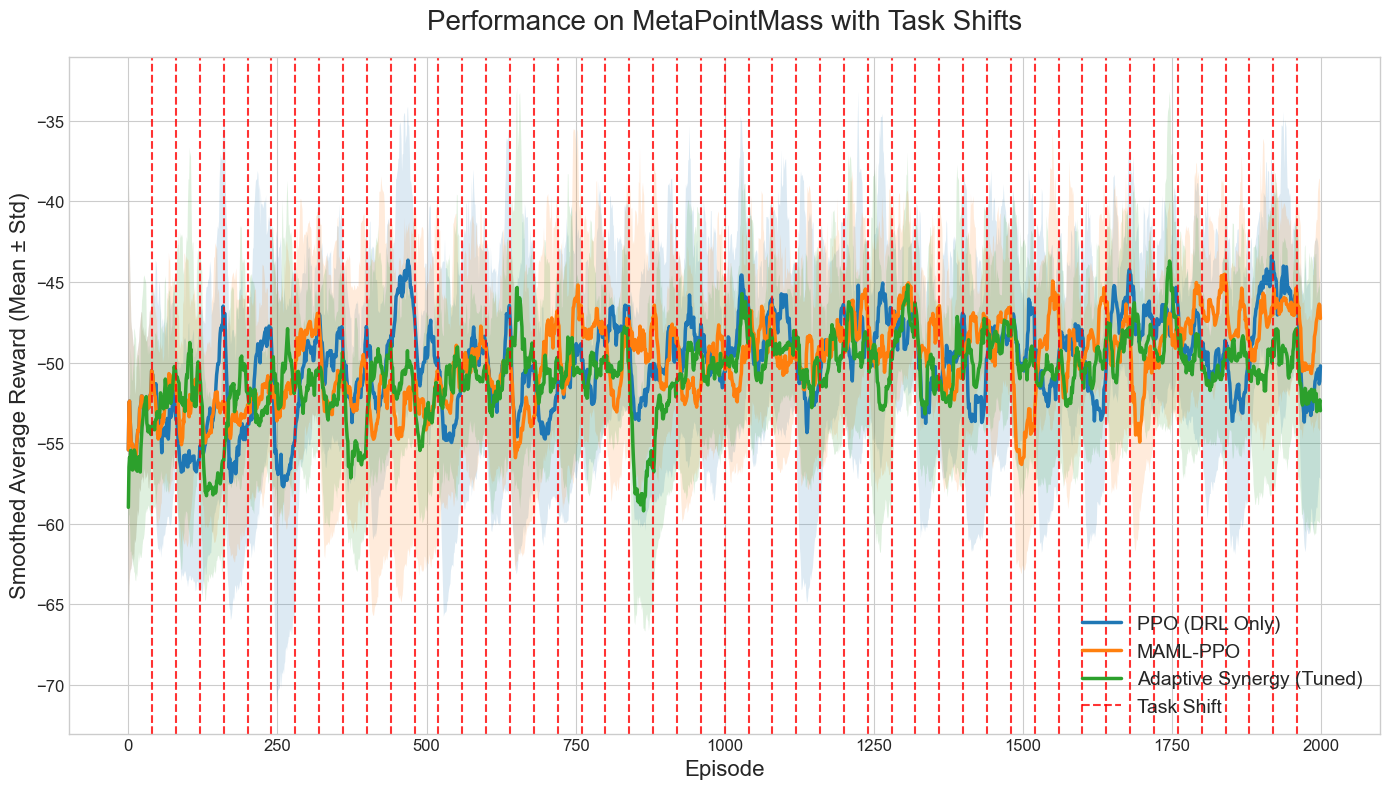


--- Robustness Analysis ---
                  Algorithm  Avg Drop  Avg Post-Shift Reward  \
0            PPO (DRL Only)      3.26                 -51.08   
1                  MAML-PPO      3.01                 -51.06   
2  Adaptive Synergy (Tuned)      1.99                 -51.15   

   Avg Episodes to Recover  
0                    33.63  
1                    33.39  
2                    32.08  


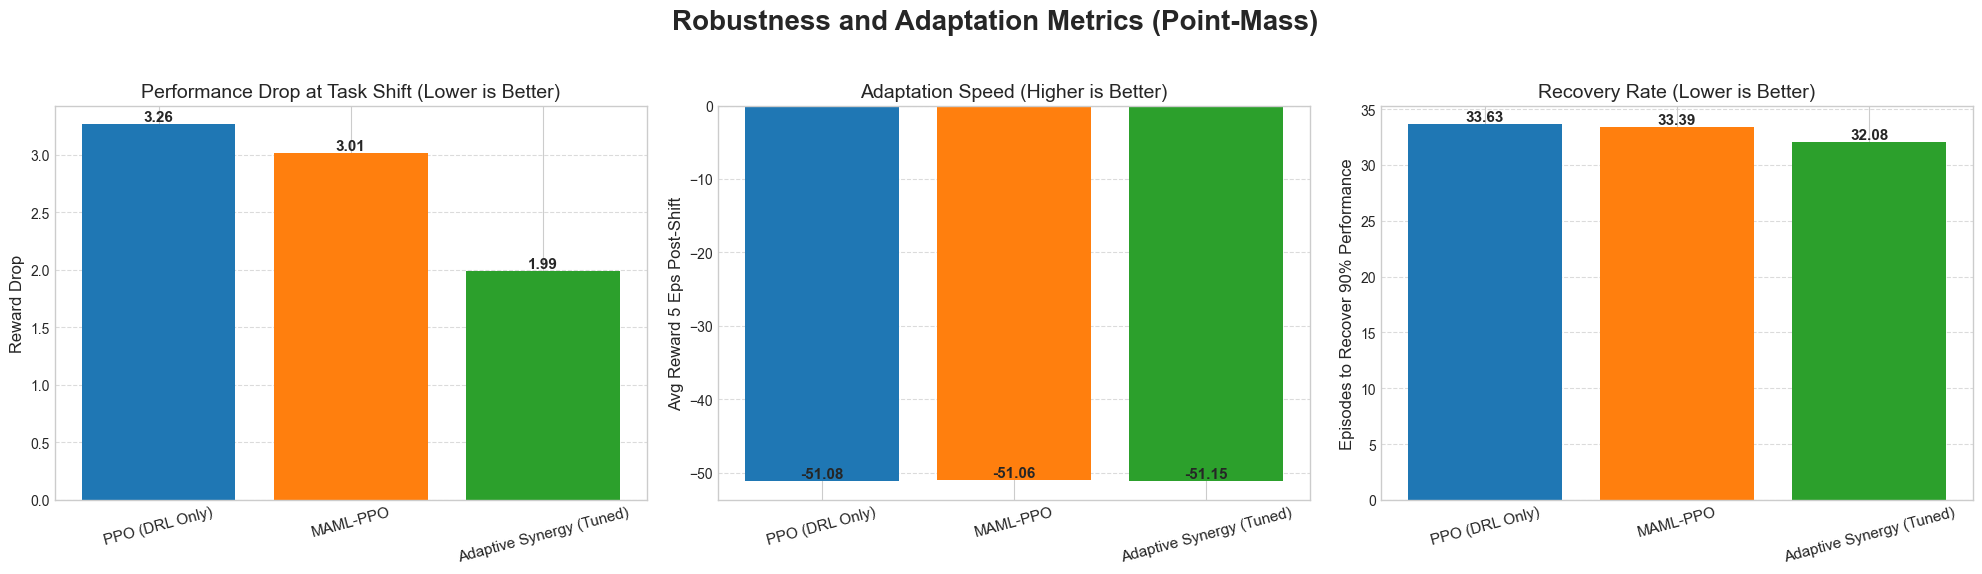

In [10]:
def plot_learning_curves(results, config):
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(14, 8))
    
    for name, data in results.items():
        mean_rewards = np.mean(data, axis=0)
        std_rewards = np.std(data, axis=0)
        
        # Use a rolling window for smoothing
        smooth_mean = pd.Series(mean_rewards).rolling(10, min_periods=1).mean()
        smooth_std = pd.Series(std_rewards).rolling(10, min_periods=1).mean()
        
        episodes = np.arange(len(smooth_mean))
        plt.plot(episodes, smooth_mean, label=name, linewidth=2.5)
        plt.fill_between(episodes, smooth_mean - smooth_std, smooth_mean + smooth_std, alpha=0.15)
    
    for ep in range(config['task_shift_interval'], config['n_episodes'], config['task_shift_interval']):
        plt.axvline(x=ep, color='r', linestyle='--', alpha=0.8, label=f'Task Shift' if ep == config['task_shift_interval'] else "")
        
    plt.title('Performance on MetaPointMass with Task Shifts', fontsize=20, pad=20)
    plt.xlabel('Episode', fontsize=16)
    plt.ylabel('Smoothed Average Reward (Mean ± Std)', fontsize=16)
    plt.legend(fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def analyze_robustness(results, config):
    shift_points = range(config['task_shift_interval'], config['n_episodes'], config['task_shift_interval'])
    robustness_data = []

    for name, data in results.items():
        all_drops, all_recoveries, all_post_shift_rewards = [], [], []
        
        for shift_ep in shift_points:
            if shift_ep >= data.shape[1]: continue
            
            pre_shift_reward = np.mean(data[:, shift_ep-10:shift_ep]) 
            post_shift_reward = np.mean(data[:, shift_ep])
            # Drop is positive, so we use max(0, drop)
            all_drops.append(max(0, pre_shift_reward - post_shift_reward))
            
            avg_post_5_reward = np.mean(data[:, shift_ep:shift_ep+5])
            all_post_shift_rewards.append(avg_post_5_reward)

            recovery_threshold = 0.9 * pre_shift_reward
            recovered = False
            for i in range(shift_ep, min(shift_ep + config['task_shift_interval'], data.shape[1])):
                current_perf = pd.Series(np.mean(data[:, :i+1], axis=0)).rolling(3).mean().iloc[-1]
                if current_perf >= recovery_threshold:
                    all_recoveries.append(i - shift_ep)
                    recovered = True
                    break
            if not recovered: all_recoveries.append(config['task_shift_interval'])

        robustness_data.append({
            "Algorithm": name,
            "Avg Drop": np.mean(all_drops),
            "Avg Post-Shift Reward": np.mean(all_post_shift_rewards),
            "Avg Episodes to Recover": np.mean(all_recoveries)
        })
    
    df = pd.DataFrame(robustness_data)
    print("\n--- Robustness Analysis ---")
    print(df.round(2))
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Robustness and Adaptation Metrics (Point-Mass)', fontsize=20, weight='bold')
    
    algorithms = df['Algorithm']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    axes[0].bar(algorithms, df['Avg Drop'], color=colors)
    axes[0].set_title('Performance Drop at Task Shift (Lower is Better)', fontsize=14)
    axes[0].set_ylabel('Reward Drop', fontsize=12)

    axes[1].bar(algorithms, df['Avg Post-Shift Reward'], color=colors)
    axes[1].set_title('Adaptation Speed (Higher is Better)', fontsize=14)
    axes[1].set_ylabel('Avg Reward 5 Eps Post-Shift', fontsize=12)
    
    axes[2].bar(algorithms, df['Avg Episodes to Recover'], color=colors)
    axes[2].set_title('Recovery Rate (Lower is Better)', fontsize=14)
    axes[2].set_ylabel('Episodes to Recover 90% Performance', fontsize=12)
    
    for ax in axes:
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.tick_params(axis='x', rotation=15, labelsize=11)
        for bar in ax.patches:
            ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(), f'{bar.get_height():.2f}', 
                    ha='center', va='bottom', fontsize=11, weight='bold')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- Generate Plots and Analysis ---
if 'all_results' in locals() and all_results:
    plot_learning_curves(all_results, CONFIG)
    analyze_robustness(all_results, CONFIG)
else:
    print("Please run the experiment and/or tuning cells first.")